In [1]:
%load_ext jupyternotify
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)

<IPython.core.display.Javascript object>

In [2]:
raw_data = pd.read_csv('../data/data_neutral.csv', index_col=[0])

In [3]:
data = raw_data.copy()

In [4]:
data.head()

,pitcher,player_name,throws_right,release_pos_x,release_pos_z,fastball_2pct,breaking_2pct,off_speed_2pct,launch_speed,solid_rate,GB_rate,LD_rate,FB_rate,PU_rate,whiff_rate,OSwing_pct,K_9,hit_9,BB_9,HR_9,release_speed_breaking,release_speed_fastball,release_speed_off_speed,pfx_x_breaking,pfx_x_fastball,pfx_x_off_speed,pfx_z_breaking,pfx_z_fastball,pfx_z_off_speed,release_spin_rate_breaking,release_spin_rate_fastball,release_spin_rate_off_speed,spin_axis_fastball,spin_axis_off_speed
0,282332,"Sabathia, CC",0,-2.315865,5.899743,0.596050,0.277678,0.126272,86.436909,0.135647,0.419558,0.189274,0.318612,0.072555,0.227384,0.295455,9.000000,9.420561,3.532710,2.271028,79.214871,88.547490,82.674408,-0.905711,0.293876,0.735024,0.102931,0.830402,0.645924,2208.381466,2156.420683,1884.739336,194.813253,228.061611
1,407845,"Rodney, Fernando",1,-2.164653,6.046254,0.679623,0.032980,0.287397,87.611628,0.116279,0.527132,0.217054,0.178295,0.077519,0.222222,0.306522,9.517986,9.323741,5.244604,0.971223,86.257143,93.801906,82.965164,0.189286,-0.923969,-1.259139,0.615357,1.166707,0.643811,2253.607143,2085.337955,1751.614754,218.008666,242.942623
2,425794,"Wainwright, Adam",1,-1.339804,6.171098,0.599158,0.363931,0.036911,88.176289,0.123711,0.486254,0.231100,0.224227,0.056701,0.176648,0.264175,8.077686,8.256198,2.856198,1.071074,74.087055,87.814780,82.926754,1.451246,-0.325698,-1.164254,-1.119364,0.815742,0.648728,2792.212189,2263.033234,1733.600877,187.216428,228.030702
3,425844,"Greinke, Zack",1,-1.269014,6.336909,0.461538,0.314077,0.224385,87.213761,0.125880,0.465989,0.231431,0.226740,0.071931,0.202007,0.303299,7.542594,8.164236,1.574827,1.077513,77.142191,89.339069,86.774393,0.794046,-0.230577,-1.056294,-0.363297,1.342422,0.347689,2421.696579,2284.299258,1692.246357,193.415655,238.265094
4,429719,"Jackson, Edwin",1,-1.842316,5.938597,0.651074,0.273006,0.075920,90.920732,0.211382,0.434959,0.268293,0.215447,0.081301,0.205298,0.239658,6.916256,13.965517,4.655172,3.059113,84.938764,92.717197,86.971717,0.286489,-0.398363,-1.319394,0.051910,0.947727,1.055556,2321.207865,2264.943463,2221.454545,197.404005,231.161616


# Standard-scale data

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [6]:
data_std = data.copy()

In [7]:
for i in data.columns[3:]:
    data_std[i] = scaler.fit_transform(data[[i]])

In [8]:
data_std.head()

,pitcher,player_name,throws_right,release_pos_x,release_pos_z,fastball_2pct,breaking_2pct,off_speed_2pct,launch_speed,solid_rate,GB_rate,LD_rate,FB_rate,PU_rate,whiff_rate,OSwing_pct,K_9,hit_9,BB_9,HR_9,release_speed_breaking,release_speed_fastball,release_speed_off_speed,pfx_x_breaking,pfx_x_fastball,pfx_x_off_speed,pfx_z_breaking,pfx_z_fastball,pfx_z_off_speed,release_spin_rate_breaking,release_spin_rate_fastball,release_spin_rate_off_speed,spin_axis_fastball,spin_axis_off_speed
0,282332,"Sabathia, CC",0,-0.547886,0.107543,0.109660,-0.049288,-0.055396,-1.212597,-0.123259,-0.360197,-0.891727,1.707820,-0.540799,0.088381,0.663420,0.090509,0.413008,-0.364793,1.587126,-0.861799,-1.734511,-0.974182,-1.946140,0.843609,1.253149,0.675416,-0.830334,0.117681,-0.893905,-0.560386,0.558454,-1.087490,-0.487359
1,407845,"Rodney, Fernando",1,-0.325049,0.412105,0.844812,-1.943539,1.407994,-0.474276,-0.723315,1.009887,-0.056674,-1.214032,-0.399936,-0.028721,0.980175,0.356909,0.354362,0.887441,-0.777481,1.150140,0.379045,-0.877219,-0.129367,-0.781237,-0.763319,1.820443,0.186724,0.111367,-0.706723,-1.016363,0.063014,0.311044,0.400184
2,425794,"Wainwright, Adam",1,0.890503,0.671624,0.136999,0.618410,-0.866996,-0.119382,-0.493045,0.489261,0.365527,-0.257578,-0.990677,-1.062663,-0.231836,-0.383837,-0.292282,-0.859654,-0.595831,-2.326788,-2.029239,-0.890028,1.964424,0.016974,-0.667373,-2.055827,-0.874668,0.126060,1.522478,0.123506,-0.004027,-1.545530,-0.489203
3,425844,"Greinke, Zack",1,0.994824,1.016306,-1.073580,0.232480,0.835699,-0.724339,-0.425868,0.231157,0.375481,-0.205252,-0.558506,-0.487349,0.887941,-0.659035,-0.347987,-1.796965,-0.584117,-1.453952,-1.416104,0.393099,0.874025,0.143885,-0.558205,-0.366380,0.718123,-0.773582,-0.011027,0.259922,-0.157933,-1.171757,0.121204
4,429719,"Jackson, Edwin",1,0.149968,0.188311,0.593676,-0.085454,-0.512703,1.605523,2.223208,-0.164046,1.483538,-0.440398,-0.292634,-0.412679,-0.933544,-0.981161,3.166031,0.456277,3.020812,0.773486,-0.057273,0.458904,0.031908,-0.079974,-0.824248,0.561409,-0.475518,1.341846,-0.426934,0.135760,1.811583,-0.931285,-0.302467


# PCA

In [42]:
X = data_std[data_std.columns[16:19]]

In [43]:
from sklearn.decomposition import PCA

In [44]:
pca = PCA(n_components=3).fit(X)
transformed = pca.transform(X)
print(transformed.shape)

(728, 3)


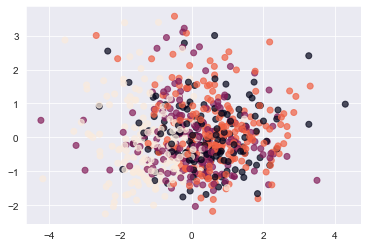

In [45]:
xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs, ys, alpha=0.7, c=labels_KM[4])
plt.show()

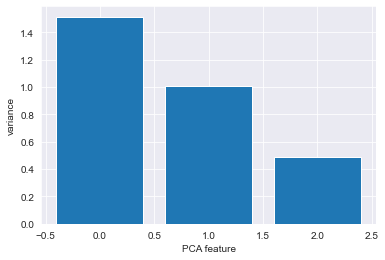

In [46]:
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()

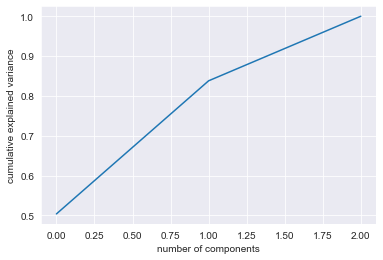

In [47]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# K-means

In [15]:
from sklearn.cluster import KMeans

In [48]:
X = data_std[data_std.columns[16:19]]

In [49]:
sse = {}
labels_KM = {}
for i in range(1,21):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    labels_KM[i] = kmeans.labels_
    sse[i] = kmeans.inertia_

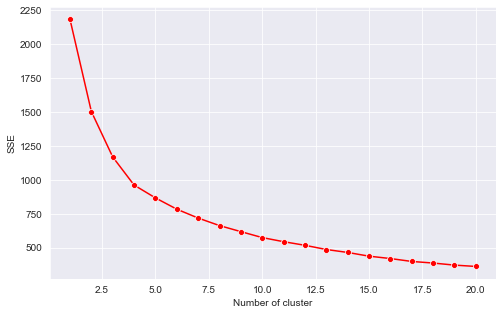

In [50]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.lineplot(x=sse.keys(), y=sse.values(), marker='o', color='red')

plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

(array([279.,   0.,   0., 143.,   0.,   0., 147.,   0.,   0., 159.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

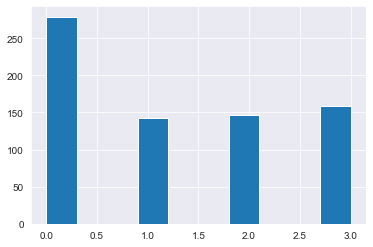

In [51]:
plt.hist(labels_KM[4])

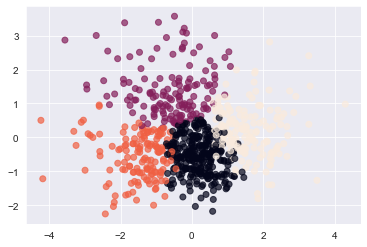

In [58]:
pca = PCA(n_components=3).fit(X)
transformed = pca.transform(X)
xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs, ys, alpha=0.7, c=labels_KM[4])
plt.show()

# Hierarchical

In [20]:
from scipy.cluster.hierarchy import linkage, dendrogram
mergings = linkage(X, method='complete', metric='correlation')

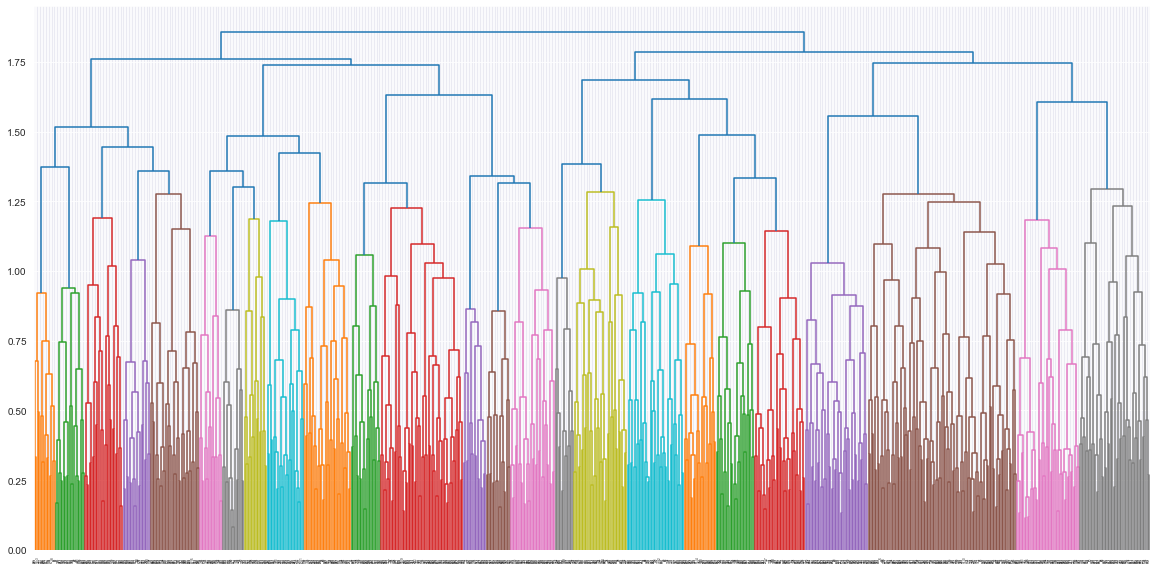

In [21]:
fig, ax = plt.subplots(figsize=(20, 10))
dn = dendrogram(mergings, leaf_rotation=90, leaf_font_size=3, ax=ax)
plt.show()

In [22]:
from scipy.cluster.hierarchy import fcluster
labels_HC = fcluster(mergings, 1.5, criterion='distance')
set(labels_HC)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

(array([108.,  99.,  73.,  60.,  47.,  37.,  79.,  41.,  97.,  87.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <BarContainer object of 10 artists>)

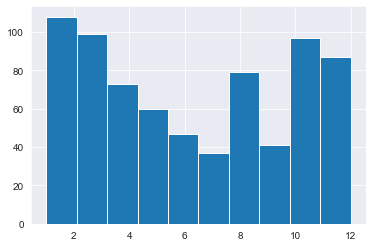

In [23]:
plt.hist(labels_HC)

# GMM

For production stats + contact: use n_components=4 and random_state=100

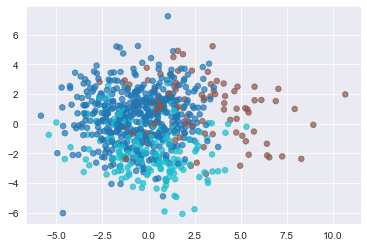

In [40]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, max_iter=100, random_state=0).fit(X)
labels_GMM = gmm.predict(X)
plt.scatter(xs, ys, c=labels_GMM, s=30, cmap='tab10', alpha=0.7);

(array([466.,   0.,   0.,   0.,   0.,  94.,   0.,   0.,   0., 168.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

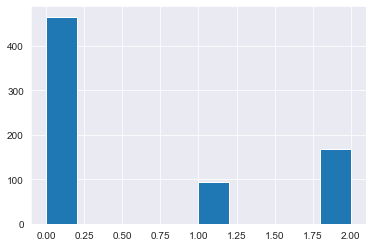

In [41]:
plt.hist(labels_GMM)

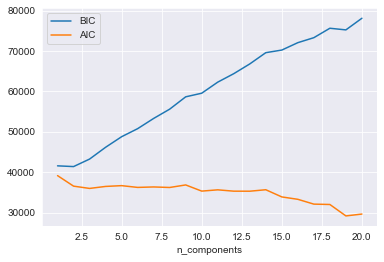

In [26]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

# Export Cluster File

In [27]:
cluster = data[data.columns[:3]].copy()

In [28]:
cluster['labels_KM'] = labels_KM[4]
cluster['labels_HC'] = labels_HC
cluster['labels_GMM'] = labels_GMM
cluster.head()

,pitcher,player_name,throws_right,labels_KM,labels_HC,labels_GMM
0,282332,"Sabathia, CC",0,0,10,2
1,407845,"Rodney, Fernando",1,1,3,1
2,425794,"Wainwright, Adam",1,2,7,0
3,425844,"Greinke, Zack",1,2,1,0
4,429719,"Jackson, Edwin",1,2,8,0


In [29]:
# cluster.to_csv('../data/cluster.csv')